# Makemore MLP with batch normalisation

## Imports + dataset construction

In [36]:
from collections import deque
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import bisect


words = open('names.txt').read().splitlines()

# Utility dicts
stoi = {c:i+1 for i,c in enumerate(sorted(set("".join(words))))}
stoi["."] = 0
itos = {i:c for c,i in stoi.items()}

In [37]:
# Create the dataset
CONTEXT_WINDOW = 3
def build_dataset(wds):
    X,Y = [],[]
    for w in wds:
        window = deque([0]*CONTEXT_WINDOW,maxlen=CONTEXT_WINDOW)
        for c in w + ".":
            ix = stoi[c]
            X.append(list(window))
            Y.append(ix)
            # print(''.join(itos[i] for i in window), '--->', itos[ix])
            window.append(ix)
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape,Y.shape)
    return X,Y

random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## Model with BatchNorm - Manual implementation

**Keys to note**:

- Batch Normalisation layer added in after the preactivation of the hidden layer to ensure unit gaussian preacts on initialisation.
- BatchNorm layer has its own bngain and bnbias to be learned via backprop. This removes need for bias in hidden layer as it will be subtracted in the BatchNorm layer anyway and a separate bias will be added

**Issue** -> Batch normalisation leads to coupling of examples, we use a different sample mean/sd per batch.

This means for inference, we need to either calculate the overall sample mean/sd as an additional step,

OR

we can use a running mean/sd during training that will converge on the total sample mean/sd estimate

In [ ]:
# Embedding Layer
N = 10
C = torch.randn((27,N))
emb = C[Xtr]

# Linear Layer (no bias needed)
W1 = torch.randn((N*CONTEXT_WINDOW,300))
# b1 = torch.randn(300) * 0.01
embcat = emb.view(-1,N*CONTEXT_WINDOW)
preact = embcat @ W1

# BatchNorm layer
bngain = torch.ones(300)
bnbias = torch.zeros(300)
# Initialise running mean/std
bnmean_running = torch.zeros((1, 300))
bnstd_running = torch.ones((1, 300))

# Output layer

W2 = torch.randn((300,27)) / 300 **0.5
b2 = torch.randn(27) * 0

parameters = [C, W1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

In [ ]:
milestones = [50000, 75000, 100000]
values = [0.1, 0.05, 0.03,0.01]
losses = []
steps = []
for i in range(150000):
    # Batch feature vectors
    ix = torch.randint(0, Xtr.shape[0], (64,))
    emb = C[Xtr[ix]]
    embcat = emb.view(-1,N*CONTEXT_WINDOW)
    # Linear layer
    preact = embcat @ W1
    # BatchNorm layer
    bnmeani = preact.mean(0, keepdim=True)
    bnstdi = preact.std(0, keepdim=True)
    preact = bngain * (preact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # Nonlinearity
    h = torch.tanh(preact)
    # Output Layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = values[bisect.bisect_right(milestones, i)]
    for p in parameters:
        p.data -= p.grad * lr
    steps.append(i)
    losses.append(loss.item())
    if i % 1000 == 0:
        print(loss.item())


### Results

The loss achieved with the Batch Norm layer is comparable to that with just kaiming init scaling on initialisation

In [ ]:
plt.plot(steps, losses, "g" )
plt.suptitle("Loss Fluctuation vs steps", fontweight='bold')
plt.title("Training on the training set")
plt.show()

Training loss

In [ ]:
emb = C[Xtr]
preact = emb.view(-1,N*CONTEXT_WINDOW) @ W1
preact = bngain * (preact - bnmean_running) / bnstd_running + bnbias
h = torch.tanh(preact)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

Test loss

In [ ]:
emb = C[Xte]
preact = emb.view(-1,N*CONTEXT_WINDOW) @ W1
preact = bngain * (preact - bnmean_running) / bnstd_running + bnbias
h = torch.tanh(preact)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

We can see that the result of the tanh neurons are not saturated, even if we remove the kaiming init factor from the initialisation of W1.

In [ ]:
plt.imshow((h.abs() > 0.99)[:32], cmap = 'gray' )

For inference, we use the running mean/std calculated

In [ ]:
for _ in range(100):

    out = []
    context = [0] * CONTEXT_WINDOW
    while True:
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        preact = emb.view(-1,N*CONTEXT_WINDOW) @ W1
        preact = bngain * (preact - bnmean_running) / bnstd_running + bnbias
        h = torch.tanh(preact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

## Model with BatchNorm - Pytorch style implementation with diagnostic plots

### Model

Layer classes like pytorch

In [128]:
class Linear:
    def __init__(self, ni: int, no: int, bias: bool=True):
        self.w = torch.randn((ni,no)) / ni **0.5
        self.bias = torch.randn(no) * 0 if bias else None

    def __call__(self, x):
        self.output = x @ self.w + (self.bias if self.bias is not None else 0)
        return self.output

    def parameters(self):
        return [self.w, self.bias] if self.bias is not None else [self.w]

class BatchNorm1d:
    def __init__(self, ni: int, eps: float=1e-5, momentum: float=0.1):
        self.eps = eps
        self.momentum = momentum
        self.ni = ni
        self.gamma = torch.ones(ni)
        self.beta = torch.zeros(ni)
        self.training = True
        self.running_mean = torch.zeros(ni)
        self.running_var = torch.ones(ni)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        x_standard = (x - xmean) / (xvar + self.eps)**0.5
        self.output = self.gamma * x_standard + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.output

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.output = torch.tanh(x)
        return self.output
    def parameters(self):
        return []

N = 10
VOCAB_SIZE = 27
HIDDEN_SIZE = 100
C = torch.randn((VOCAB_SIZE,N))

# layers = [
#     Linear(N*CONTEXT_WINDOW, HIDDEN_SIZE), Tanh(),
#     Linear(HIDDEN_SIZE, HIDDEN_SIZE), Tanh(),
#     Linear(HIDDEN_SIZE, HIDDEN_SIZE), Tanh(),
#     Linear(HIDDEN_SIZE, HIDDEN_SIZE), Tanh(),
#     Linear(HIDDEN_SIZE, VOCAB_SIZE),
# ]

layers = [
    Linear(N*CONTEXT_WINDOW, HIDDEN_SIZE, bias = False), BatchNorm1d(HIDDEN_SIZE), Tanh(),
    Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias = False), BatchNorm1d(HIDDEN_SIZE), Tanh(),
    Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias = False), BatchNorm1d(HIDDEN_SIZE), Tanh(),
    Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias = False), BatchNorm1d(HIDDEN_SIZE), Tanh(),
    Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias = False)
    ,
]
# layers = [
#     Linear(N*CONTEXT_WINDOW, HIDDEN_SIZE),
#     Linear(HIDDEN_SIZE, HIDDEN_SIZE),
#     Linear(HIDDEN_SIZE, HIDDEN_SIZE),
#     Linear(HIDDEN_SIZE, HIDDEN_SIZE),
#     Linear(HIDDEN_SIZE, VOCAB_SIZE),
# ]

with torch.no_grad():
    layers[-1].w *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.w *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True


44070


In [129]:
lr = 0.1
losses = []
updates = []

for i in range(200000):
    # Indices of the batch
    ix = torch.randint(0,Xtr.shape[0],(64,))

    # Get batch embeddings
    emb = C[Xtr[ix]]
    x = emb.view(-1,N*CONTEXT_WINDOW)
    # Forward through all layers
    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, Ytr[ix])
    # Backward
    for layer in layers:
        layer.output.retain_grad()

    for p in parameters:
        p.grad = None

    loss.backward()

    for p in parameters:
        p.data -= p.grad * lr

    # Stat tracking
    if i % 10000 == 0:
        print(f"{i}: {loss.item():.3f}")
    losses.append(loss.item())
    with torch.no_grad():
        updates.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    # break


0: 4.603
10000: 2.124
20000: 2.220
30000: 2.352
40000: 2.027
50000: 1.769
60000: 2.132
70000: 1.989
80000: 2.212
90000: 1.914
100000: 2.086
110000: 2.022
120000: 1.789
130000: 2.119
140000: 2.325
150000: 1.843
160000: 1.802
170000: 1.901
180000: 2.267
190000: 2.240


### Plots

Losses of the deeper network:

more overfitting as more params

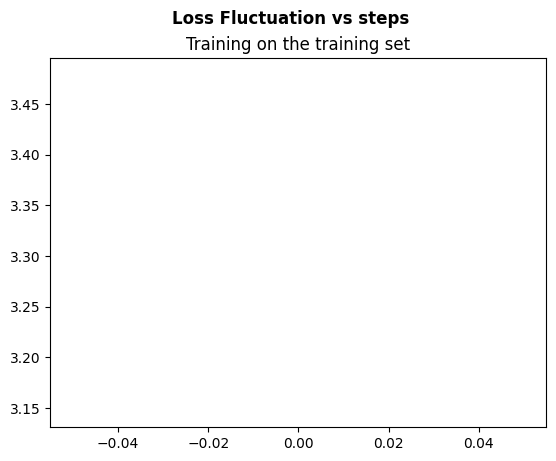

In [95]:
plt.plot(range(len(losses)), losses, "g" )
plt.suptitle("Loss Fluctuation vs steps", fontweight='bold')
plt.title("Training on the training set")
plt.show()

In [96]:
# emb = C[Xtr]
# x = emb.view(-1,N*CONTEXT_WINDOW)
# for layer in layers:
#     x = layer(x)
# loss = F.cross_entropy(x, Ytr)
# loss

In [97]:
# emb = C[Xte]
# x = emb.view(-1,N*CONTEXT_WINDOW)
# for layer in layers:
#     x = layer(x)
# loss = F.cross_entropy(x, Yte)
# loss

#### Activations of layers

Notes:

- If we don't add any gain, with just linear and tanh layers, the activations will squeeze in over time due to the tanh function decreasing the variance of the input distribution. Hence, add a 5/3 gain.
- If we don't have any activations, the standard gaussian is preserved through the layers due to the fan_in scaling factor of the weights.

layer 1 (      Tanh): mean -0.03, std 0.74, saturated: 19.20%
layer 3 (      Tanh): mean -0.09, std 0.69, saturated: 9.30%
layer 5 (      Tanh): mean +0.01, std 0.67, saturated: 7.17%
layer 7 (      Tanh): mean -0.00, std 0.65, saturated: 5.78%


Text(0.5, 1.0, 'activation distribution')

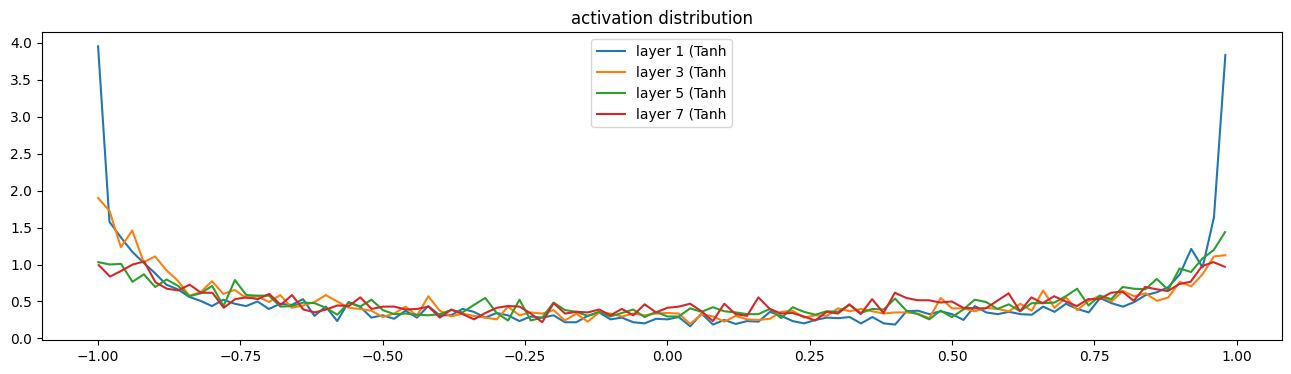

In [108]:
figure = plt.figure(figsize=(16, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.output
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

#### Gradients of layers

Notes:

- We can see that with stable/homogenous activation distributions across the layers, the gradients are all similarly distributed through the layers. This demonstrates that there is no significant vanishing of gradients and the network is learning effectively
- If there is significant saturation in the tanh, the gradients have

layer 1 (      Tanh): mean -0.00, std 0.000195
layer 3 (      Tanh): mean -0.00, std 0.000187
layer 5 (      Tanh): mean -0.00, std 0.000171
layer 7 (      Tanh): mean +0.00, std 0.000156


Text(0.5, 1.0, 'gradients')

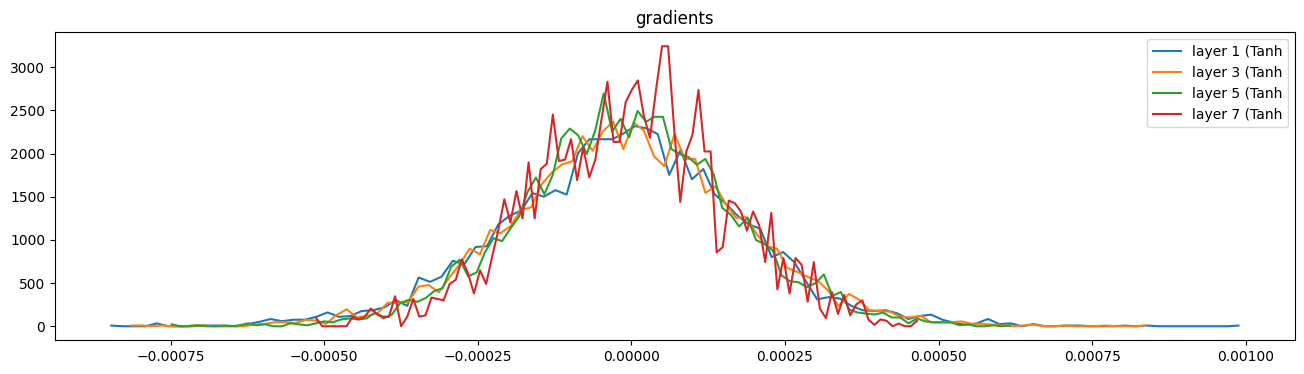

In [109]:
figure = plt.figure(figsize=(16, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.output.grad
    print('layer %d (%10s): mean %+.2f, std %f' % (i, layer.__class__.__name__, t.mean(), t.std() ) )
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradients')

#### Updates of layers over time

We want the update to data ratio to be about 1e-3, if under, not learning fast enough, if too high, unstable.

- Check LR, Initialisations etc



In [115]:
print(updates[0])

[-4.017101287841797, -3.4811136722564697, -0.16696245968341827, -3.289642095565796, -0.2024400234222412, -3.3504860401153564, -0.20515449345111847, -3.3969998359680176, -0.20976553857326508, -0.7329398989677429, -0.24688750505447388]


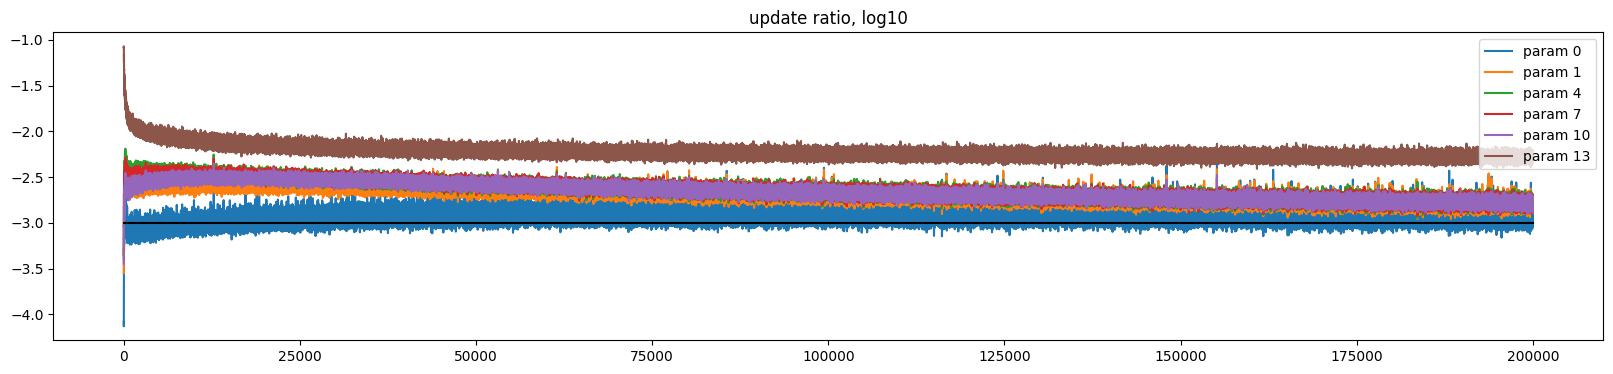

In [130]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([updates[j][i] for j in range(len(updates))])
    legends.append('param %d' % i)
plt.plot([0, len(updates)], [-3, -3], 'k')
plt.title('update ratio, log10')
plt.legend(legends);

Batch Norm layers can be sprinkled through the NN to maintain stability in the activations by initialising with gaussian